# Piano MIDI Generation - Model Training

This notebook handles training the transformer model on the processed MIDI dataset.

## Overview

1. **Load model and data** - From architecture notebook
2. **Training setup** - Optimizer, scheduler, loss function
3. **Training loop** - Forward/backward passes, gradient updates
4. **Validation** - Monitor performance on held-out data
5. **Checkpointing** - Save best model
6. **Monitoring** - Track loss, learning rate, metrics

## Training Strategy

- **Small dataset** → Use regularization (dropout, weight decay)
- **Small dataset** → Early stopping to prevent overfitting
- **Monitor validation loss** → Save best model
- **Learning rate scheduling** → Warmup + cosine decay


In [1]:
# Import PyTorch and detect available GPUs
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Import model from architecture notebook (or reload)
# If running standalone, you'll need to import/recreate the model
from IPython.display import clear_output

print("✅ Libraries imported")

# Check available GPUs
if torch.cuda.is_available():
    print(f"✅ CUDA available - Found {torch.cuda.device_count()} GPU(s):")
    for i in range(torch.cuda.device_count()):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        print(f"   GPU {i}: {gpu_name} ({gpu_memory:.2f} GB)")
else:
    print("⚠️  CUDA not available")


✅ Libraries imported
✅ CUDA available - Found 1 GPU(s):
   GPU 0: NVIDIA GeForce GTX 1650 (4.29 GB)


## Step 1: Load Model and Data

Load the model architecture, vocabulary, and data loaders.  
**Note:** Run `02_model_architecture.ipynb` first, or recreate model here.


In [2]:
# Load data
data_dir = Path("processed_data")

with open(data_dir / "vocab.json", 'r') as f:
    vocab = json.load(f)

with open(data_dir / "id_to_token.json", 'r') as f:
    id_to_token = json.load(f)

with open(data_dir / "sequences.json", 'r') as f:
    sequences = json.load(f)

# Convert id_to_token keys to int
id_to_token = {int(k): v for k, v in id_to_token.items()}

vocab_size = len(vocab)
pad_token_id = vocab.get('<PAD>', 0)

print(f"✅ Loaded vocabulary: {vocab_size:,} tokens")
print(f"✅ Loaded {len(sequences):,} sequences")


✅ Loaded vocabulary: 746 tokens
✅ Loaded 3,843 sequences


In [3]:
# Load model config
with open(data_dir / "preprocessing_config.json", 'r') as f:
    preprocess_config = json.load(f)

# Model configuration
MODEL_CONFIG = {
    'vocab_size': vocab_size,
    'max_seq_length': preprocess_config['max_sequence_length'],
    'd_model': 512,
    'n_layers': 6,
    'n_heads': 8,
    'd_ff': 2048,
    'dropout': 0.1,
    'pad_token_id': pad_token_id,
}

# Import model classes from shared module
# This is cleaner than duplicating code between notebooks
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))

try:
    from model import PianoMIDIGenerator, PositionalEncoding, TransformerBlock
    print("✅ Model classes imported from model.py")
except ImportError:
    print("⚠️  Could not import from model.py")
    print("   Attempting to import from architecture notebook namespace...")
    # Fallback: try to use classes if architecture notebook was run in same kernel
    try:
        # Test if classes exist from previous notebook
        _ = PianoMIDIGenerator
        print("✅ Using model classes from architecture notebook")
    except NameError:
        print("❌ Model classes not found!")
        print("   Please either:")
        print("   1. Run 02_model_architecture.ipynb in the same kernel, OR")
        print("   2. Ensure model.py exists with model classes")
        raise


✅ Model classes imported from model.py


## Step 2: Training Configuration

Set hyperparameters optimized for small dataset.


In [4]:
# Training Configuration
from pathlib import Path  # Ensure Path is available
import math  # For learning rate scheduler

TRAIN_CONFIG = {
    'num_epochs': 50,              # Max epochs (early stopping will likely trigger earlier)
    'learning_rate': 6e-4,         # Initial learning rate
    'weight_decay': 0.1,            # L2 regularization (important for small dataset)
    'warmup_steps': 500,            # Learning rate warmup steps
    'max_grad_norm': 1.0,          # Gradient clipping
    'batch_size': 2,                # Reduced batch size for 4GB GPU (was 8)
    'accumulation_steps': 4,        # Increased accumulation (effective batch = 8, was 16)
    'eval_steps': 100,              # Evaluate every N steps
    'save_steps': 500,              # Save checkpoint every N steps
    'patience': 5,                  # Early stopping patience (epochs)
    'checkpoint_dir': Path("checkpoints"),
}

print("Training Configuration:")
for key, value in TRAIN_CONFIG.items():
    print(f"  {key}: {value}")

# Create checkpoint directory
TRAIN_CONFIG['checkpoint_dir'].mkdir(exist_ok=True)


Training Configuration:
  num_epochs: 50
  learning_rate: 0.0006
  weight_decay: 0.1
  warmup_steps: 500
  max_grad_norm: 1.0
  batch_size: 2
  accumulation_steps: 4
  eval_steps: 100
  save_steps: 500
  patience: 5
  checkpoint_dir: checkpoints


## Step 3: Setup Optimizer, Scheduler, and Loss

Configure training components with learning rate scheduling.


In [5]:
# Setup device - Use available GPU
torch.cuda.empty_cache()  # Clear any existing CUDA cache

if torch.cuda.is_available():
    # Use GPU 0 (NVIDIA GeForce GTX 1650)
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)  # Set as default
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    print(f"✅ Using GPU: {gpu_name}")
    print(f"   Total memory: {gpu_memory:.2f} GB")
    
    # Show current memory usage
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1e9
        reserved = torch.cuda.memory_reserved(0) / 1e9
        print(f"   Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
else:
    device = torch.device('cpu')
    print("⚠️  Using CPU (no CUDA available)")
    print("   Make sure PyTorch CUDA is installed correctly")

# Clear CUDA cache before training
torch.cuda.empty_cache()

# Import Dataset for MIDIDataset class
from torch.utils.data import Dataset

# Recreate dataset and dataloaders if needed
# (Copy from architecture notebook or recreate here)
class MIDIDataset(Dataset):
    """Dataset for MIDI token sequences"""
    def __init__(self, sequences, vocab, max_length=2048):
        self.sequences = sequences
        self.vocab = vocab
        self.pad_token_id = vocab.get('<PAD>', 0)
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        token_ids = self.sequences[idx]['token_ids']
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        input_ids = token_ids[:-1]
        target_ids = token_ids[1:]
        pad_len = self.max_length - len(input_ids)
        if pad_len > 0:
            input_ids = input_ids + [self.pad_token_id] * pad_len
            target_ids = target_ids + [self.pad_token_id] * pad_len
        attention_mask = [1] * len(token_ids[:-1]) + [0] * pad_len
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'target_ids': torch.tensor(target_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
        }

dataset = MIDIDataset(sequences, vocab, max_length=MODEL_CONFIG['max_seq_length'])
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"✅ Dataset created: Train={len(train_dataset)}, Val={len(val_dataset)}")

# Initialize model if not already created
# This assumes PianoMIDIGenerator class exists (from architecture notebook)
# If not, you need to copy the model class definitions here first

# Create model instance
if 'model' not in locals():
    model = PianoMIDIGenerator(MODEL_CONFIG)
    print(f"✅ Model created: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
else:
    print(f"✅ Using existing model: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

# Move model to device
model = model.to(device)

# Verify model is on GPU
if torch.cuda.is_available():
    print(f"✅ Model device: {next(model.parameters()).device}")
    print(f"✅ Model on GPU: {next(model.parameters()).is_cuda}")
    
    # Show GPU memory before training
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    print(f"✅ GPU memory (model loaded):")
    print(f"   Allocated: {allocated:.2f} GB")
    print(f"   Reserved: {reserved:.2f} GB")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=TRAIN_CONFIG['learning_rate'],
    weight_decay=TRAIN_CONFIG['weight_decay'],
    betas=(0.9, 0.95)
)

# Learning rate scheduler
def get_lr_scheduler(optimizer, num_training_steps, warmup_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, num_training_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_steps = len(train_loader) * TRAIN_CONFIG['num_epochs'] // TRAIN_CONFIG['accumulation_steps']
scheduler = get_lr_scheduler(optimizer, total_steps, TRAIN_CONFIG['warmup_steps'])

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)

print(f"\n✅ Training setup complete:")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: Cosine with {TRAIN_CONFIG['warmup_steps']} step warmup")
print(f"  Total training steps: {total_steps:,}")


✅ Using GPU: NVIDIA GeForce GTX 1650
   Total memory: 4.29 GB
   Allocated: 0.00 GB, Reserved: 0.00 GB
✅ Dataset created: Train=3458, Val=385
✅ Model created: 19.7M parameters
✅ Model device: cuda:0
✅ Model on GPU: True
✅ GPU memory (model loaded):
   Allocated: 0.09 GB
   Reserved: 0.09 GB

✅ Training setup complete:
  Optimizer: AdamW
  Scheduler: Cosine with 500 step warmup
  Total training steps: 21,612


## Step 4: Training and Validation Functions

Define training step, validation, and checkpointing.


## ⚠️ IMPORTANT: GPU Selection

**If you see errors about GPU 0 (AMD card), restart the kernel and run cells in order.**

The `CUDA_VISIBLE_DEVICES` environment variable must be set **before** importing PyTorch. 
If you've already imported torch, restart the kernel and run all cells from the beginning.


In [6]:
# Training metrics tracking
import math  # For math.isnan, math.isinf checks

train_losses = []
val_losses = []
learning_rates = []
best_val_loss = float('inf')
steps_without_improvement = 0

def train_step(model, batch, optimizer, criterion, accumulation_steps, global_step):
    """Single training step"""
    model.train()
    
    # Move data to GPU (async transfer if pin_memory is True)
    input_ids = batch['input_ids'].to(device, non_blocking=True)
    attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    target_ids = batch['target_ids'].to(device, non_blocking=True)
    
    # Check for NaN/inf in inputs
    if torch.isnan(input_ids).any() or torch.isinf(input_ids).any():
        raise ValueError("NaN or Inf found in input_ids!")
    if torch.isnan(target_ids).any() or torch.isinf(target_ids).any():
        raise ValueError("NaN or Inf found in target_ids!")
    
    # Forward pass
    logits = model(input_ids, attention_mask=attention_mask)
    
    # Check for NaN/inf in logits
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("⚠️  WARNING: NaN or Inf in logits!")
        print(f"   Logits stats: min={logits.min().item():.2f}, max={logits.max().item():.2f}, mean={logits.mean().item():.2f}")
        print(f"   NaN count: {torch.isnan(logits).sum().item()}, Inf count: {torch.isinf(logits).sum().item()}")
        # Replace NaN/Inf with finite values
        logits = torch.nan_to_num(logits, nan=0.0, posinf=10.0, neginf=-10.0)
    
    # Reshape for loss
    logits_flat = logits.view(-1, vocab_size)
    targets_flat = target_ids.view(-1)
    
    # Compute loss (only on non-padded tokens)
    loss = criterion(logits_flat, targets_flat)
    
    # Check for NaN/inf in loss
    if torch.isnan(loss) or torch.isinf(loss):
        print("⚠️  WARNING: NaN or Inf in loss!")
        print(f"   Loss value: {loss.item()}")
        return float('nan')  # Return NaN to skip this step
    
    # Normalize loss by accumulation steps
    loss = loss / accumulation_steps
    
    # Backward pass
    loss.backward()
    
    # Check for NaN gradients
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                print(f"⚠️  WARNING: NaN or Inf in gradients at step {global_step}!")
                print(f"   Param shape: {param.shape}")
                param.grad = torch.nan_to_num(param.grad, nan=0.0, posinf=1.0, neginf=-1.0)
            grad_norm += param.grad.data.norm(2).item() ** 2
    grad_norm = grad_norm ** 0.5
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), TRAIN_CONFIG['max_grad_norm'])
    
    # Update weights (only if accumulation complete)
    if (global_step + 1) % accumulation_steps == 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Sync GPU operations after optimizer step
        if torch.cuda.is_available():
            torch.cuda.synchronize()
    
    return loss.item() * accumulation_steps  # Return unscaled loss

def validate(model, val_loader, criterion):
    """Validation loop"""
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            target_ids = batch['target_ids'].to(device, non_blocking=True)
            
            # Forward pass
            logits = model(input_ids, attention_mask=attention_mask)
            
            # Check for NaN/inf in logits
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("⚠️  WARNING: NaN or Inf in validation logits!")
                logits = torch.nan_to_num(logits, nan=0.0, posinf=10.0, neginf=-10.0)
            
            # Compute loss (only on non-padded tokens)
            logits_flat = logits.view(-1, vocab_size)
            targets_flat = target_ids.view(-1)
            
            # Mask out padded tokens for loss computation
            mask = (targets_flat != pad_token_id)
            
            # Compute loss only on valid tokens
            if mask.sum() > 0:
                loss = criterion(logits_flat, targets_flat)
                
                # Check for NaN/inf
                if torch.isnan(loss) or torch.isinf(loss):
                    continue  # Skip this batch
                
                # Accumulate loss weighted by number of valid tokens
                total_loss += loss.item() * mask.sum().item()
                total_tokens += mask.sum().item()
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    
    # Final NaN check
    if math.isnan(avg_loss) or math.isinf(avg_loss):
        return float('inf')
    
    return avg_loss

def save_checkpoint(model, optimizer, scheduler, epoch, step, val_loss, is_best=False):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
    }
    
    checkpoint_dir = TRAIN_CONFIG['checkpoint_dir']
    
    # Save latest
    torch.save(checkpoint, checkpoint_dir / 'checkpoint_latest.pt')
    
    # Save best
    if is_best:
        torch.save(checkpoint, checkpoint_dir / 'checkpoint_best.pt')
        print(f"  💾 Saved best model (val_loss: {val_loss:.4f})")

print("✅ Training functions defined")


✅ Training functions defined


In [7]:
# Checkpoint resumption function
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    """Load checkpoint and resume training state"""
    if not checkpoint_path.exists():
        return None
    
    print(f"📂 Found checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Load scheduler state
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # Return training state
    return {
        'epoch': checkpoint['epoch'],
        'step': checkpoint['step'],
        'val_loss': checkpoint['val_loss'],
        'train_losses': checkpoint.get('train_losses', []),
        'val_losses': checkpoint.get('val_losses', []),
        'learning_rates': checkpoint.get('learning_rates', []),
    }

# Check for existing checkpoints and resume if found
checkpoint_dir = TRAIN_CONFIG['checkpoint_dir']
latest_checkpoint = checkpoint_dir / 'checkpoint_latest.pt'
best_checkpoint = checkpoint_dir / 'checkpoint_best.pt'

# Try to resume from latest checkpoint (has most recent training state)
resume_from_checkpoint = None
if latest_checkpoint.exists():
    print("=" * 60)
    print("🔄 Found existing checkpoint - attempting to resume training...")
    print("=" * 60)
    resume_state = load_checkpoint(latest_checkpoint, model, optimizer, scheduler)
    if resume_state:
        resume_from_checkpoint = resume_state
        print(f"\n✅ Successfully loaded checkpoint:")
        print(f"   Last epoch: {resume_state['epoch'] + 1}")
        print(f"   Last step: {resume_state['step']:,}")
        print(f"   Last val loss: {resume_state['val_loss']:.4f}")
        print(f"   Training history: {len(resume_state['train_losses'])} train losses, {len(resume_state['val_losses'])} val losses")
        print(f"\n📊 Resuming from:")
        print(f"   Epoch: {resume_state['epoch'] + 2} / {TRAIN_CONFIG['num_epochs']}")
        print(f"   Step: {resume_state['step']:,}")
elif best_checkpoint.exists():
    print("=" * 60)
    print("⚠️  Only best checkpoint found (no latest checkpoint)")
    print("   Will resume from best checkpoint but training history may be incomplete")
    print("=" * 60)
    resume_state = load_checkpoint(best_checkpoint, model, optimizer, scheduler)
    if resume_state:
        resume_from_checkpoint = resume_state
        print(f"\n✅ Loaded best checkpoint:")
        print(f"   Best epoch: {resume_state['epoch'] + 1}")
        print(f"   Best step: {resume_state['step']:,}")
        print(f"   Best val loss: {resume_state['val_loss']:.4f}")
        print(f"\n📊 Resuming from:")
        print(f"   Epoch: {resume_state['epoch'] + 2} / {TRAIN_CONFIG['num_epochs']}")
        print(f"   Step: {resume_state['step']:,}")
else:
    print("=" * 60)
    print("📝 No existing checkpoint found - starting fresh training")
    print("=" * 60)

# Main training loop
print("\n🚀 Starting training...")
print("=" * 60)

# GPU verification before training starts
if torch.cuda.is_available():
    print(f"✅ Training will use GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ Model parameters on: {next(model.parameters()).device}")
    
    # Test a small forward pass to ensure GPU works
    print("\n🔍 Testing GPU computation...")
    model.eval()
    with torch.no_grad():
        test_batch = next(iter(train_loader))
        test_input = test_batch['input_ids'][:1].to(device, non_blocking=True)
        test_mask = test_batch['attention_mask'][:1].to(device, non_blocking=True)
        test_output = model(test_input, attention_mask=test_mask)
        print(f"✅ GPU test passed! Output shape: {test_output.shape}, Device: {test_output.device}")
        
        # Show GPU memory after test
        allocated = torch.cuda.memory_allocated(0) / 1e9
        reserved = torch.cuda.memory_reserved(0) / 1e9
        print(f"✅ GPU memory (after test):")
        print(f"   Allocated: {allocated:.2f} GB")
        print(f"   Reserved: {reserved:.2f} GB")
    model.train()
    print("")

# Initialize or restore training state
if resume_from_checkpoint:
    # Restore from checkpoint
    global_step = resume_from_checkpoint['step']
    best_val_loss = resume_from_checkpoint['val_loss']
    train_losses = resume_from_checkpoint['train_losses']
    val_losses = resume_from_checkpoint['val_losses']
    learning_rates = resume_from_checkpoint['learning_rates']
    start_epoch = resume_from_checkpoint['epoch'] + 1  # Continue from next epoch
    
    # Calculate steps_without_improvement based on validation history
    if len(val_losses) > 1:
        # Count how many consecutive evaluations showed no improvement
        steps_without_improvement = 0
        current_best = float('inf')
        for v_loss in val_losses:
            if v_loss < current_best:
                current_best = v_loss
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1
    else:
        steps_without_improvement = 0
    
    print(f"\n✅ Resuming training:")
    print(f"   Starting epoch: {start_epoch + 1}")
    print(f"   Starting step: {global_step:,}")
    print(f"   Current best val loss: {best_val_loss:.4f}")
else:
    # Start fresh
    global_step = 0
    best_val_loss = float('inf')
    steps_without_improvement = 0
    start_epoch = 0
    print(f"\n✅ Starting fresh training from epoch 1, step 0")

# Resume from checkpoint epoch if applicable
for epoch in range(start_epoch, TRAIN_CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{TRAIN_CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Training
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")
    
    for batch_idx, batch in enumerate(pbar):
        # Verify batch is on GPU (first batch only)
        if batch_idx == 0 and global_step == 0:
            if torch.cuda.is_available():
                print(f"🔍 First batch verification:")
                print(f"   Input device: {batch['input_ids'].device}")
                print(f"   After .to(device): {(batch['input_ids'].to(device, non_blocking=True).device)}")
        
        # Training step
        loss = train_step(
            model, batch, optimizer, criterion,
            TRAIN_CONFIG['accumulation_steps'],
            global_step
        )
        
        # Check for NaN loss (skip if NaN)
        if math.isnan(loss) or math.isinf(loss):
            print(f"\n⚠️  WARNING: Skipping step {global_step} due to NaN/Inf loss!")
            optimizer.zero_grad()  # Clear gradients
            continue  # Skip this batch
        
        # Sync GPU operations every batch to ensure computation happens
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # Force GPU operations to complete before next batch
        
        epoch_losses.append(loss)
        train_losses.append(loss)
        
        # Update learning rate tracking
        current_lr = scheduler.get_last_lr()[0]
        learning_rates.append(current_lr)
        
        # Update progress bar (handle NaN)
        avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('nan')
        loss_str = f'{loss:.4f}' if not (math.isnan(loss) or math.isinf(loss)) else 'nan'
        avg_loss_str = f'{avg_loss:.4f}' if not (math.isnan(avg_loss) or math.isinf(avg_loss)) else 'nan'
        
        pbar.set_postfix({
            'loss': loss_str,
            'lr': f'{current_lr:.2e}',
            'avg_loss': avg_loss_str
        })
        
        global_step += 1
        
        # Validation
        if global_step % TRAIN_CONFIG['eval_steps'] == 0:
            val_loss = validate(model, val_loader, criterion)
            
            # Check for NaN validation loss
            if math.isnan(val_loss) or math.isinf(val_loss):
                print(f"\n⚠️  WARNING: Validation loss is NaN/Inf at step {global_step}!")
                val_loss = float('inf')  # Treat as worst case
            
            val_losses.append(val_loss)
            
            print(f"\n  Step {global_step}: Val Loss = {val_loss:.4f}")
            
            # Check for improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                steps_without_improvement = 0
                save_checkpoint(model, optimizer, scheduler, epoch, global_step, val_loss, is_best=True)
            else:
                steps_without_improvement += 1
            
            # Early stopping check
            if steps_without_improvement >= TRAIN_CONFIG['patience'] * (len(train_loader) // TRAIN_CONFIG['eval_steps']):
                print(f"\\n⚠️  Early stopping triggered! No improvement for {steps_without_improvement} evaluations.")
                break
        
        # Save checkpoint periodically
        if global_step % TRAIN_CONFIG['save_steps'] == 0:
            current_val_loss = validate(model, val_loader, criterion) if val_losses else best_val_loss
            save_checkpoint(model, optimizer, scheduler, epoch, global_step, current_val_loss, is_best=False)
    
    # Epoch summary
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"\\nEpoch {epoch + 1} Summary:")
    print(f"  Avg Train Loss: {avg_epoch_loss:.4f}")
    if val_losses:
        print(f"  Best Val Loss: {best_val_loss:.4f}")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    
    # Early stopping
    if steps_without_improvement >= TRAIN_CONFIG['patience'] * (len(train_loader) // TRAIN_CONFIG['eval_steps']):
        break

print("\\n✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")


🔄 Found existing checkpoint - attempting to resume training...
📂 Found checkpoint: checkpoints\checkpoint_latest.pt

✅ Successfully loaded checkpoint:
   Last epoch: 13
   Last step: 15,700
   Last val loss: 2.2036
   Training history: 15700 train losses, 157 val losses

📊 Resuming from:
   Epoch: 14 / 50
   Step: 15,700

🚀 Starting training...
✅ Training will use GPU: NVIDIA GeForce GTX 1650
✅ Model parameters on: cuda:0

🔍 Testing GPU computation...
✅ GPU test passed! Output shape: torch.Size([1, 2048, 746]), Device: cuda:0
✅ GPU memory (after test):
   Allocated: 0.26 GB
   Reserved: 1.18 GB


✅ Resuming training:
   Starting epoch: 14
   Starting step: 15,700
   Current best val loss: 2.2036

Epoch 14/50
------------------------------------------------------------


Training Epoch 14:   6%|▌         | 99/1729 [04:02<1:04:07,  2.36s/it, loss=2.4159, lr=5.61e-04, avg_loss=2.2566]


  Step 15800: Val Loss = 2.1958


Training Epoch 14:   6%|▌         | 100/1729 [05:29<12:57:13, 28.63s/it, loss=2.4159, lr=5.61e-04, avg_loss=2.2566]

  💾 Saved best model (val_loss: 2.1958)


Training Epoch 14:  12%|█▏        | 200/1729 [10:28<9:22:28, 22.07s/it, loss=2.2027, lr=5.61e-04, avg_loss=2.2612] 


  Step 15900: Val Loss = 2.1958


Training Epoch 14:  17%|█▋        | 299/1729 [14:07<51:28,  2.16s/it, loss=2.3268, lr=5.60e-04, avg_loss=2.2561]  


  Step 16000: Val Loss = 2.1920
  💾 Saved best model (val_loss: 2.1920)


Training Epoch 14:  23%|██▎       | 400/1729 [21:08<8:10:04, 22.13s/it, loss=2.1877, lr=5.60e-04, avg_loss=2.2559] 


  Step 16100: Val Loss = 2.1980


Training Epoch 14:  29%|██▉       | 500/1729 [25:54<7:31:22, 22.04s/it, loss=2.0927, lr=5.59e-04, avg_loss=2.2580]


  Step 16200: Val Loss = 2.1925


Training Epoch 14:  35%|███▍      | 599/1729 [29:35<40:43,  2.16s/it, loss=2.6283, lr=5.59e-04, avg_loss=2.2592]  


  Step 16300: Val Loss = 2.1889


Training Epoch 14:  35%|███▍      | 600/1729 [30:42<7:00:26, 22.34s/it, loss=2.6283, lr=5.59e-04, avg_loss=2.2592]

  💾 Saved best model (val_loss: 2.1889)


Training Epoch 14:  40%|████      | 699/1729 [34:22<37:17,  2.17s/it, loss=2.1608, lr=5.58e-04, avg_loss=2.2570]  


  Step 16400: Val Loss = 2.1766


Training Epoch 14:  40%|████      | 700/1729 [35:30<6:23:52, 22.38s/it, loss=2.1608, lr=5.58e-04, avg_loss=2.2570]

  💾 Saved best model (val_loss: 2.1766)


Training Epoch 14:  46%|████▌     | 799/1729 [39:09<33:25,  2.16s/it, loss=2.1736, lr=5.57e-04, avg_loss=2.2529]  


  Step 16500: Val Loss = 2.1829


Training Epoch 14:  52%|█████▏    | 900/1729 [46:10<5:05:41, 22.13s/it, loss=1.7313, lr=5.57e-04, avg_loss=2.2510] 


  Step 16600: Val Loss = 2.1825


Training Epoch 14:  58%|█████▊    | 999/1729 [49:50<26:15,  2.16s/it, loss=2.0926, lr=5.56e-04, avg_loss=2.2496]  


  Step 16700: Val Loss = 2.1736


Training Epoch 14:  58%|█████▊    | 1000/1729 [50:57<4:31:00, 22.30s/it, loss=2.0926, lr=5.56e-04, avg_loss=2.2496]

  💾 Saved best model (val_loss: 2.1736)


Training Epoch 14:  64%|██████▎   | 1099/1729 [54:37<22:37,  2.15s/it, loss=2.1531, lr=5.56e-04, avg_loss=2.2499]  


  Step 16800: Val Loss = 2.1664


Training Epoch 14:  64%|██████▎   | 1100/1729 [55:44<3:54:01, 22.32s/it, loss=2.1531, lr=5.56e-04, avg_loss=2.2499]

  💾 Saved best model (val_loss: 2.1664)


Training Epoch 14:  69%|██████▉   | 1199/1729 [59:25<19:05,  2.16s/it, loss=2.1816, lr=5.55e-04, avg_loss=2.2493]  


  Step 16900: Val Loss = 2.1611


Training Epoch 14:  69%|██████▉   | 1200/1729 [1:00:32<3:16:39, 22.31s/it, loss=2.1816, lr=5.55e-04, avg_loss=2.2493]

  💾 Saved best model (val_loss: 2.1611)


Training Epoch 14:  75%|███████▌  | 1299/1729 [1:04:12<15:32,  2.17s/it, loss=2.4052, lr=5.54e-04, avg_loss=2.2511]  


  Step 17000: Val Loss = 2.1519
  💾 Saved best model (val_loss: 2.1519)


Training Epoch 14:  81%|████████  | 1400/1729 [1:11:14<2:01:21, 22.13s/it, loss=2.3146, lr=5.54e-04, avg_loss=2.2496]


  Step 17100: Val Loss = 2.1552


Training Epoch 14:  87%|████████▋ | 1500/1729 [1:16:02<1:24:21, 22.10s/it, loss=2.1821, lr=5.53e-04, avg_loss=2.2470]


  Step 17200: Val Loss = 2.1530


Training Epoch 14:  93%|█████████▎| 1600/1729 [1:20:49<47:26, 22.07s/it, loss=2.2278, lr=5.53e-04, avg_loss=2.2457]  


  Step 17300: Val Loss = 2.1615


Training Epoch 14:  98%|█████████▊| 1700/1729 [1:25:37<10:40, 22.09s/it, loss=2.2850, lr=5.52e-04, avg_loss=2.2452]


  Step 17400: Val Loss = 2.1533


Training Epoch 14: 100%|██████████| 1729/1729 [1:26:41<00:00,  3.01s/it, loss=2.3614, lr=5.52e-04, avg_loss=2.2448]


\nEpoch 14 Summary:
  Avg Train Loss: 2.2448
  Best Val Loss: 2.1519
  Learning Rate: 5.52e-04

Epoch 15/50
------------------------------------------------------------


Training Epoch 15:   4%|▍         | 70/1729 [02:36<59:57,  2.17s/it, loss=2.0202, lr=5.51e-04, avg_loss=2.2094]  


  Step 17500: Val Loss = 2.1410
  💾 Saved best model (val_loss: 2.1410)


Training Epoch 15:  10%|▉         | 170/1729 [08:31<56:23,  2.17s/it, loss=1.9299, lr=5.51e-04, avg_loss=2.2038]  


  Step 17600: Val Loss = 2.1407


Training Epoch 15:  10%|▉         | 171/1729 [09:38<9:38:30, 22.28s/it, loss=1.9299, lr=5.51e-04, avg_loss=2.2038]

  💾 Saved best model (val_loss: 2.1407)


Training Epoch 15:  16%|█▌        | 270/1729 [13:19<52:44,  2.17s/it, loss=2.1503, lr=5.50e-04, avg_loss=2.1996]  


  Step 17700: Val Loss = 2.1336


Training Epoch 15:  16%|█▌        | 271/1729 [14:26<9:02:01, 22.31s/it, loss=2.1503, lr=5.50e-04, avg_loss=2.1996]

  💾 Saved best model (val_loss: 2.1336)


Training Epoch 15:  21%|██▏       | 370/1729 [18:07<49:05,  2.17s/it, loss=2.2275, lr=5.50e-04, avg_loss=2.1974]  


  Step 17800: Val Loss = 2.1314


Training Epoch 15:  21%|██▏       | 371/1729 [19:14<8:23:54, 22.26s/it, loss=2.2275, lr=5.50e-04, avg_loss=2.1974]

  💾 Saved best model (val_loss: 2.1314)


Training Epoch 15:  27%|██▋       | 470/1729 [22:55<45:33,  2.17s/it, loss=1.7625, lr=5.49e-04, avg_loss=2.1899]  


  Step 17900: Val Loss = 2.1304


Training Epoch 15:  27%|██▋       | 471/1729 [24:02<7:47:24, 22.29s/it, loss=1.7625, lr=5.49e-04, avg_loss=2.1899]

  💾 Saved best model (val_loss: 2.1304)


Training Epoch 15:  33%|███▎      | 570/1729 [27:43<41:57,  2.17s/it, loss=2.2513, lr=5.48e-04, avg_loss=2.1885]  


  Step 18000: Val Loss = 2.1406


Training Epoch 15:  39%|███▉      | 670/1729 [37:30<50:04,  2.84s/it, loss=2.5427, lr=5.48e-04, avg_loss=2.1894]   


  Step 18100: Val Loss = 2.1257


Training Epoch 15:  39%|███▉      | 671/1729 [41:03<19:36:42, 66.73s/it, loss=2.5427, lr=5.48e-04, avg_loss=2.1894]

  💾 Saved best model (val_loss: 2.1257)


Training Epoch 15:  45%|████▍     | 770/1729 [45:52<45:11,  2.83s/it, loss=2.3121, lr=5.47e-04, avg_loss=2.1912]   


  Step 18200: Val Loss = 2.1244


Training Epoch 15:  45%|████▍     | 771/1729 [47:00<6:05:56, 22.92s/it, loss=2.3121, lr=5.47e-04, avg_loss=2.1912]

  💾 Saved best model (val_loss: 2.1244)


Training Epoch 15:  50%|█████     | 870/1729 [51:49<40:54,  2.86s/it, loss=2.2395, lr=5.47e-04, avg_loss=2.1914]  


  Step 18300: Val Loss = 2.1219


Training Epoch 15:  50%|█████     | 871/1729 [52:57<5:28:28, 22.97s/it, loss=2.2395, lr=5.47e-04, avg_loss=2.1914]

  💾 Saved best model (val_loss: 2.1219)


Training Epoch 15:  56%|█████▌    | 970/1729 [57:46<35:47,  2.83s/it, loss=2.0654, lr=5.46e-04, avg_loss=2.1887]  


  Step 18400: Val Loss = 2.1182


Training Epoch 15:  56%|█████▌    | 971/1729 [58:53<4:49:14, 22.89s/it, loss=2.0654, lr=5.46e-04, avg_loss=2.1887]

  💾 Saved best model (val_loss: 2.1182)


Training Epoch 15:  62%|██████▏   | 1070/1729 [1:03:43<31:02,  2.83s/it, loss=2.0591, lr=5.45e-04, avg_loss=2.1865]


  Step 18500: Val Loss = 2.1253


Training Epoch 15:  68%|██████▊   | 1170/1729 [1:10:54<33:52,  3.64s/it, loss=2.0478, lr=5.45e-04, avg_loss=2.1848]  


KeyboardInterrupt: 

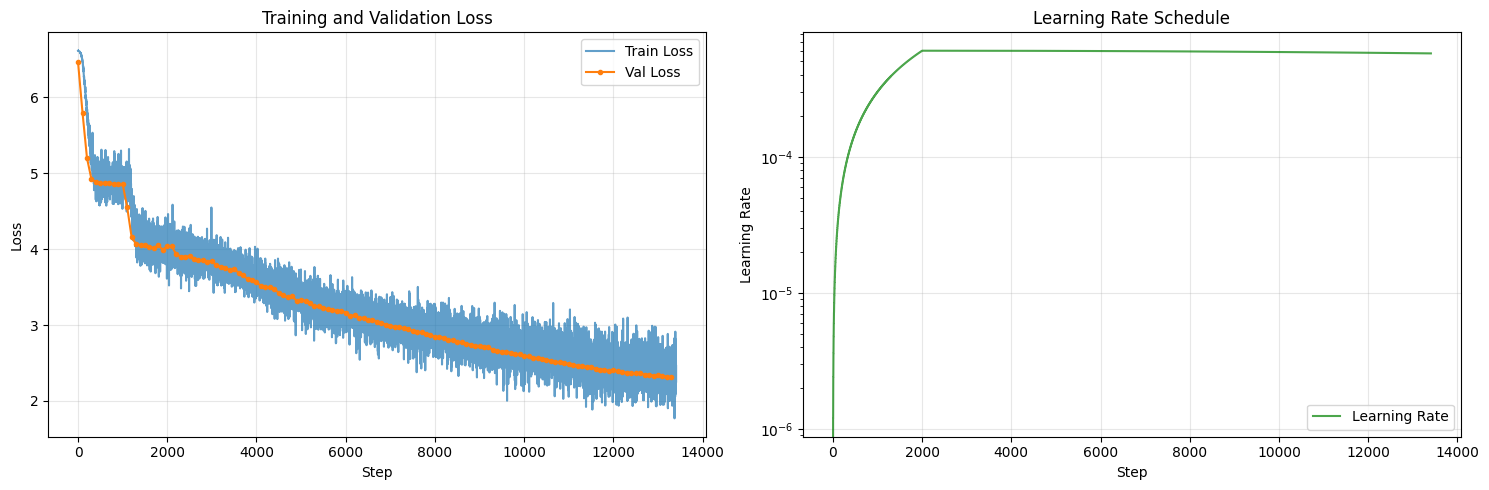

✅ Training curves saved to: checkpoints\training_curves.png


In [8]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', alpha=0.7)
if val_losses:
    # Interpolate val losses to match train steps
    val_steps = [i * TRAIN_CONFIG['eval_steps'] for i in range(len(val_losses))]
    axes[0].plot(val_steps, val_losses, label='Val Loss', marker='o', markersize=3)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1].plot(learning_rates, label='Learning Rate', color='green', alpha=0.7)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(TRAIN_CONFIG['checkpoint_dir'] / 'training_curves.png', dpi=150)
plt.show()

print(f"✅ Training curves saved to: {TRAIN_CONFIG['checkpoint_dir'] / 'training_curves.png'}")


## Step 7: Load Best Model

Load the best checkpoint for generation/evaluation.


In [ ]:
# Load best model checkpoint
checkpoint_path = TRAIN_CONFIG['checkpoint_dir'] / 'checkpoint_best.pt'

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best model from epoch {checkpoint['epoch'] + 1}")
    print(f"   Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"   Training step: {checkpoint['step']:,}")
else:
    print("⚠️  No checkpoint found. Using current model state.")

# Set to evaluation mode
model.eval()

print("\\n✅ Model ready for generation/evaluation!")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
